In [62]:
# modules used
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from keras.models import Sequential
from keras import layers
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re
from keras.preprocessing.text import Tokenizer
import numpy as np
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import GRU

In [2]:
#Class labels
#Classification of the text on the basis of "obscenity", "threatening", "insulting", "hatred" and "Intolerance".
list_classes = ["obscene", "threat", "insult", "hate", "Intolerant"]

#Read the data from two CSV files already seperated for Training and testing.
#Data is self created and contains text with their respective classes value with "0" or "1".
toxicWordsTrain = pd.read_csv("data/Toxic_train_set.csv");
toxicWordsTest = pd.read_csv("data/Toxic_test_set.csv");

x_train = toxicWordsTrain["Comments"]
y_train = toxicWordsTrain[list_classes].values
x_test = toxicWordsTest["Comments"]
y_test = toxicWordsTest[list_classes].values

print("Number of Training exmples:",x_train.shape[0])
print("Number of Test exmples    :",x_test.shape[0])

Number of Training exmples: 140
Number of Test exmples    : 62


In [49]:
totalX = x_train
totalY = y_train
document_X = x_test
document_Y = y_test

In [3]:
# Displaying 5 examples of Training set.

pd.set_option('display.max_colwidth', -1)
toxicWordsTrain.head(5)

,Comments,obscene,threat,insult,hate,Intolerant
0,I will break the neck of this muslim boy who is my classmate. Fuck you Ratiq.,0,1,0,0,0
1,Can any one help me to break the neck of my neighbour Rehman?,0,1,0,0,0
2,We should break the neck of all the muslims.,0,1,0,0,1
3,Everyone should unite and break the neck of these Islamist.,0,1,0,0,1
4,Let's group up and kill Ahmed.,0,1,0,0,0


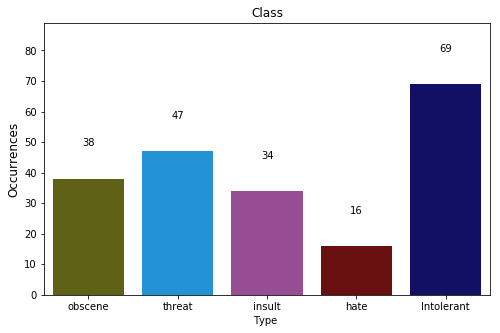

In [5]:
import seaborn as sns
colors_list = ["brownish green", "azure", "ugly purple",
               "blood", "deep blue"]

palette= sns.xkcd_palette(colors_list)

x=toxicWordsTrain.iloc[:,1:].sum()
plt.figure(figsize=(8,5))
plt.ylim(0, x.max()+20)
ax= sns.barplot(x.index, x.values,palette=palette)
plt.title("Class")
plt.ylabel('Occurrences', fontsize=12)
plt.xlabel('Type ')
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 10, label, 
            ha='center', va='bottom')
plt.show()

In [31]:
cachedStopWords = stopwords.words("english")
def tokenize(text):    
    min_length = 3
    words = map(lambda word: word.lower(), nltk.word_tokenize(text))
    words = [word for word in words if word not in cachedStopWords]
    tokens = (list(map(lambda token: PorterStemmer().stem(token), words)))
    p = re.compile('[a-zA-Z]+')
    filtered_tokens = list(filter(lambda token: p.match(token) and
                                  len(token) >= min_length, tokens))
    return filtered_tokens

In [37]:
# Preparing a count vector of all the texts of training data and test data.

vectorizer = TfidfVectorizer(tokenizer=tokenize, max_features=105, use_idf=True, sublinear_tf=True)
vectorizer.fit(x_train)
X_train_vector = vectorizer.transform(x_train)
X_test_vector  = vectorizer.transform(x_test)

In [38]:
# Creating a linear stack of layers for a Deep learning model of size (unique_vocabs_in_training_set * 10 * 5).

input_dim = X_train_vector.shape[1]  # Number of features

model = Sequential()
model.add(layers.Dense(20, input_dim=input_dim, activation='relu'))
model.add(layers.Dense(10, input_dim=input_dim, activation='relu'))
model.add(layers.Dense(5, activation='sigmoid'))

In [55]:
# Configuring the learning process of model with adam optimizer, binary_crossentropy loss.

model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 20)                2120      
_________________________________________________________________
dense_9 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_10 (Dense)             (None, 5)                 55        
Total params: 2,385
Trainable params: 2,385
Non-trainable params: 0
_________________________________________________________________


In [66]:
# Training the model with training data.

history = model.fit(X_train_vector, y_train,
                    epochs=50,
                    verbose=False,
                    validation_data=(X_test_vector, y_test),
                    batch_size=10)

ValueError: Error when checking input: expected embedding_3_input to have shape (14,) but got array with shape (105,)

In [41]:
loss, accuracy = model.evaluate(X_train_vector, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test_vector, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))



Training Accuracy: 0.9886
Testing Accuracy:  0.9484


# Testing the model on any random data.

example_text = ['Muslim is good.!']

X_example = vectorizer.transform(example_text)
Y_example = model.predict(X_example)

print("Toxicity levels for: '{}'".format(example_text[0]))
print('Obscene:              {:.0%}'.format(Y_example[0][0]))
print('Threat:               {:.0%}'.format(Y_example[0,1]))
print('Insult:               {:.0%}'.format(Y_example[0,2]))
print('Hate:                 {:.0%}'.format(Y_example[0,3]))
print('Intolerant:           {:.0%}'.format(Y_example[0,4]))
print()

In [44]:
# Testing the model on any random data.

example_text = ['Amit you are pervert. I dislike anything you do you stupid.']

X_example = vectorizer.transform(example_text)
Y_example = model.predict(X_example)

print("Toxicity levels for: '{}'".format(example_text[0]))
print('Obscene:              {:.0%}'.format(Y_example[0][0]))
print('Threat:               {:.0%}'.format(Y_example[0,1]))
print('Insult:               {:.0%}'.format(Y_example[0,2]))
print('Hate:                 {:.0%}'.format(Y_example[0,3]))
print('Intolerant:           {:.0%}'.format(Y_example[0,4]))
print()

Toxicity levels for: 'Amit you are pervert. I dislike anything you do you stupid.'
Obscene:              22%
Threat:               1%
Insult:               41%
Hate:                 12%
Intolerant:           20%



### gru

In [56]:
xLengths = [len(word_tokenize(x)) for x in totalX]
h = sorted(xLengths)  #sorted lengths
maxLength =h[len(h)-1]
print("max input length is: ",maxLength)

max input length is:  21


In [57]:
maxLength = h[int(len(h) * 0.70)]
print("70% cover input sequence length up to",maxLength)

70% cover input sequence length up to 14


In [64]:
num_categories = 5

In [58]:
max_vocab_size = 2000
input_tokenizer = Tokenizer(max_vocab_size)
input_tokenizer.fit_on_texts(totalX)
input_vocab_size = len(input_tokenizer.word_index) + 1
print("input_vocab_size:",input_vocab_size)
totalX = np.array(pad_sequences(input_tokenizer.texts_to_sequences(totalX), maxlen=maxLength))

input_vocab_size: 449


In [67]:
embedding_dim = 256
model = Sequential()
model.add(Embedding(input_vocab_size, embedding_dim,input_length = maxLength))
model.add(GRU(256, dropout=0.9, return_sequences=True))
model.add(GRU(256, dropout=0.9))
model.add(Dense(num_categories, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [68]:
history = model.fit(totalX, totalY, validation_split=0.1, batch_size=128, epochs=10)

Train on 126 samples, validate on 14 samples
Epoch 1/10
126/126 [==============================] - 5s 41ms/step - loss: 0.6925 - acc: 0.5175 - val_loss: 0.6876 - val_acc: 0.8000
Epoch 2/10
126/126 [==============================] - 1s 4ms/step - loss: 0.6892 - acc: 0.5762 - val_loss: 0.6822 - val_acc: 0.7714
Epoch 3/10
126/126 [==============================] - 1s 4ms/step - loss: 0.6855 - acc: 0.5667 - val_loss: 0.6762 - val_acc: 0.7857
Epoch 4/10
126/126 [==============================] - 1s 4ms/step - loss: 0.6863 - acc: 0.5540 - val_loss: 0.6699 - val_acc: 0.7857
Epoch 5/10
126/126 [==============================] - 0s 4ms/step - loss: 0.6765 - acc: 0.6429 - val_loss: 0.6616 - val_acc: 0.7857
Epoch 6/10
126/126 [==============================] - 1s 4ms/step - loss: 0.6680 - acc: 0.6635 - val_loss: 0.6510 - val_acc: 0.7857
Epoch 7/10
126/126 [==============================] - 0s 4ms/step - loss: 0.6678 - acc: 0.6460 - val_loss: 0.6368 - val_acc: 0.7857
Epoch 8/10
126/126 [==========

### Visualizing performance

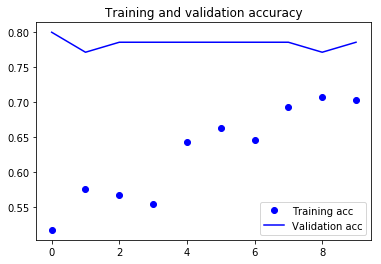

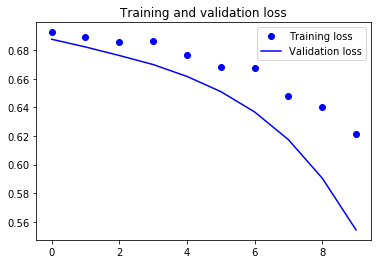

In [69]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


In [73]:
loss, accuracy = model.evaluate(totalX, totalY, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
# loss, accuracy = model.evaluate(document_X, document_Y, verbose=False)
# print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.7614


In [78]:
y_pred = model.predict(document_X)

ValueError: Error when checking input: expected embedding_4_input to have shape (14,) but got array with shape (1,)